<br><font face="Times New Roman" size=5><div dir=ltr align=center>
<font color=blue size=8>
    Introduction to Machine Learning <br>
<font color=red size=5>
    Sharif University of Technology - Computer Engineering Department <br>
    Fall 2022<br> <br>
<font color=black size=6>
    Homework 2: Practical - Decision Tree   
<font color=black size=4>
    Hamidreza Yaghoubi 
    
<br><br>
<font size=4>
In this homework, we are going to implement the Classification Decision Tree. Keep in mind to complete all of the following questions and write your own codes in the TODO cells.

<font face="Times New Roman" size=4><div dir=ltr>
# Problem 2: Classification Decision Tree (100 points)
We will implement a Classification Decision Tree from scratch in the following problem. Then we will use our model to predict malignant and benign breast cancer. For this purpose, we will use the breast_cancer.csv dataset which you can find more details about it <a href="https://www.kaggle.com/datasets/merishnasuwal/breast-cancer-prediction-dataset"><font face="Roboto">here</font></a>.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from math import log
import random
import numpy as np

<font face="Times New Roman" size=4><div dir=ltr>
## Classification Decision Tree Class (60 points)
In this section, you only need to fill TODO parts. You can find the logic and formula in both course slides and the web, but fill it out on your own. 

In [9]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        if self.value is not None:
            return True
        return False

In [2]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def is_splitting_finished(self, depth, num_class_labels, num_samples):
        if self.max_depth <= depth or num_samples <= self.min_samples_split or num_class_labels == 1:
            return True 
        else:
            return False

    def split(self, X, y, feature, threshold):
        left_indexes = X[feature] <= threshold
        right_indexes = -left_indexes
        X_left = X[left_indexes]
        y_left = y[left_indexes]
        X_right = X[right_indexes]
        y_right = y[right_indexes]

        return X_left, X_right, y_left, y_right

    def entropy(self, y):
        
        ent = 0
        p = y.sum()[0] / len(y)
        if p == 1 or p == 0:
            return 0
        
        ent = (-1) * (p * log(p, 2) + (1 - p) * log(1 - p, 2))
        return ent


    def information_gain(self, X, y, feature, threshold):
        X_left, X_right, y_left, y_right = self.split(X, y, feature, threshold)
        H_y = self.entropy(y)
        p = len(y_left)/len(y)
        if len(y_left) != 0:
            H1 = self.entropy(y_left) 
            H2 = self.entropy(y_right)
            H_y_given_x = p * H1 + (1-p) * H2
            return H_y - H_y_given_x
        if len(y_left) == 0 or len(y_right) == 0:
            return 0
        if len(y_right) != 0:
            H1 = self.entropy(y_left) 
            H2 = self.entropy(y_right)
            H_y_given_x = p * H1 + (1-p) * H2
            return H_y - H_y_given_x


    def best_split(self, X, y):

        features = list(X.columns.values)
        random.shuffle(features)
        best_information_gain = 0
        best_feature = None
        best_threshold = None
        for feature in features:
            thresholds = list(set(list(X[feature])))
            for threshold in thresholds:
                info_gain = self.information_gain(X, y, feature, threshold)
                if info_gain >= best_information_gain:
                    best_information_gain = info_gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold

    def build_tree(self, X, y, depth=0):
        if self.is_splitting_finished(depth, len(X.columns), len(X)):
            return None

        best_feature, best_threshold = self.best_split(X, y)
        X_left, X_right, y_left, y_right = self.split(X, y, best_feature, best_threshold)

        left_node = self.build_tree(X_left, y_left, depth=depth + 1)
        right_node = self.build_tree(X_right, y_right, depth=depth + 1)

        value = None
        if left_node is None or right_node is None:
            true_value = len(y[y['diagnosis'] == 1])
            false_value = len(y[y['diagnosis'] == 0])
            if true_value >= false_value:
                value = 1
            else:
                value = 0

        return Node(feature=best_feature, threshold=best_threshold, left=left_node, right=right_node, value=value)

    def fit(self, X, y):
        self.root = self.build_tree(X, y)

    def predict(self, X):
        tree = self.root
        predicted_value = []
        for index in list(X.index):
            data = X.loc[index]
            current_tree = tree
            for depth in range(self.max_depth):
                if Node.is_leaf(current_tree):
                    predicted_value.append(current_tree.value)
                    break
                feature = current_tree.feature
                threshold = current_tree.threshold
                if data[feature] <= threshold:
                    current_tree = current_tree.left
                if data[feature] > threshold:
                    current_tree = current_tree.right

        return predicted_value

<font face="Times New Roman" size=4><div dir=ltr>
## Data Prepration (20 points)
In this section, you must perform a good EDA for data. Then split it into train and validation data. We will then use the validation data to find the best model hyperparameters.  

In [3]:
breast_cancer_pdf = pd.read_csv("breast_cancer.csv")
breast_cancer_pdf

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


In [4]:
counter = 0
for item in breast_cancer_pdf.duplicated():
    if item == True:
        counter += 1
    else:
        continue

if counter == 0:
    print("There is no duplicated values in dataset")
if (breast_cancer_pdf < 0).sum().sum() ==0:
    print('There is no negative value in dataset') 
if breast_cancer_pdf.isnull().sum().sum() == 0:
    print('There is no NaN value in dataset') 

### So we made sure that our dataset is OK and doesn't have any abnormalities.


There is no duplicated values in dataset
There is no negative value in dataset
There is no NaN value in dataset


<AxesSubplot: title={'center': 'mean_texture'}, xlabel='diagnosis'>

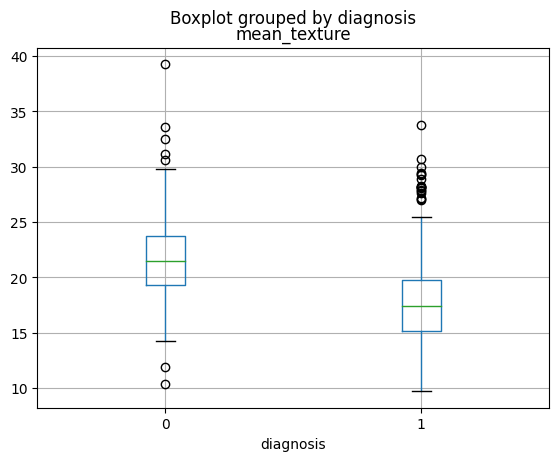

In [5]:
breast_cancer_pdf.boxplot(column = 'mean_texture', by = 'diagnosis')
#### Visualizing data by diagnosis


In [6]:
X = breast_cancer_pdf.iloc[:, 0:5]    ### Features
Y = breast_cancer_pdf.iloc[:, 5].to_frame("diagnosis")  #### Targets: diagnosis

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.70, random_state=42)

<font face="Times New Roman" size=4><div dir=ltr>
## Training And Tuning Hyperparameters (20 points)
In this section, you only need to find the best hyperparameters for your model. You can test different values and permutations of hyperparameters by adding them to the lists below. Your model must have at least accuracy=0.85 on validation data.

In [7]:
max_depths = [1, 2, 3, 4, 5, 6]
min_samples_splits = [4, 8, 16, 32]  #### Set of hyperparameters

In [10]:
best_max_depth = None
best_min_samples_split = None
best_accuracy = 0
best_model = None
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        clf = DecisionTree(max_depth, min_samples_split)
        clf.fit(x_train, y_train)
        y_val_pred = clf.predict(x_val)
        y_train_pred = clf.predict(x_train)
        accuracy = accuracy_score(y_val_pred, y_val)
        train_accuracy = accuracy_score(y_train_pred, y_train)
        print(f"accuracy of training set for [min_samples_splits={min_samples_split}-max_depths={max_depth}] ={train_accuracy}")
        print(f"accuracy of validation set for [min_samples_splits={min_samples_split}-max_depths={max_depth}] ={accuracy}")
        print("------------------------------------------------")
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
            best_model = clf
print(best_accuracy)

/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=4-max_depths=1] =0.5764705882352941
accuracy of validation set for [min_samples_splits=4-max_depths=1] =0.6491228070175439
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=8-max_depths=1] =0.5764705882352941
accuracy of validation set for [min_samples_splits=8-max_depths=1] =0.6491228070175439
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=16-max_depths=1] =0.5764705882352941
accuracy of validation set for [min_samples_splits=16-max_depths=1] =0.6491228070175439
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=32-max_depths=1] =0.5764705882352941
accuracy of validation set for [min_samples_splits=32-max_depths=1] =0.6491228070175439
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=4-max_depths=2] =0.8705882352941177
accuracy of validation set for [min_samples_splits=4-max_depths=2] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=8-max_depths=2] =0.8705882352941177
accuracy of validation set for [min_samples_splits=8-max_depths=2] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=16-max_depths=2] =0.8705882352941177
accuracy of validation set for [min_samples_splits=16-max_depths=2] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=32-max_depths=2] =0.8705882352941177
accuracy of validation set for [min_samples_splits=32-max_depths=2] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=4-max_depths=3] =0.8705882352941177
accuracy of validation set for [min_samples_splits=4-max_depths=3] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=8-max_depths=3] =0.8705882352941177
accuracy of validation set for [min_samples_splits=8-max_depths=3] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=16-max_depths=3] =0.8705882352941177
accuracy of validation set for [min_samples_splits=16-max_depths=3] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=32-max_depths=3] =0.8705882352941177
accuracy of validation set for [min_samples_splits=32-max_depths=3] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=4-max_depths=4] =0.9176470588235294
accuracy of validation set for [min_samples_splits=4-max_depths=4] =0.8721804511278195
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=8-max_depths=4] =0.888235294117647
accuracy of validation set for [min_samples_splits=8-max_depths=4] =0.8421052631578947
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=16-max_depths=4] =0.8705882352941177
accuracy of validation set for [min_samples_splits=16-max_depths=4] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=32-max_depths=4] =0.8705882352941177
accuracy of validation set for [min_samples_splits=32-max_depths=4] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=4-max_depths=5] =0.9294117647058824
accuracy of validation set for [min_samples_splits=4-max_depths=5] =0.9047619047619048
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=8-max_depths=5] =0.888235294117647
accuracy of validation set for [min_samples_splits=8-max_depths=5] =0.8421052631578947
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=16-max_depths=5] =0.8705882352941177
accuracy of validation set for [min_samples_splits=16-max_depths=5] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=32-max_depths=5] =0.8705882352941177
accuracy of validation set for [min_samples_splits=32-max_depths=5] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=4-max_depths=6] =0.9294117647058824
accuracy of validation set for [min_samples_splits=4-max_depths=6] =0.9047619047619048
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=8-max_depths=6] =0.888235294117647
accuracy of validation set for [min_samples_splits=8-max_depths=6] =0.8421052631578947
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=16-max_depths=6] =0.8705882352941177
accuracy of validation set for [min_samples_splits=16-max_depths=6] =0.8771929824561403
------------------------------------------------


/var/folders/08/p1z1c8c126l84xc2g6szk34w0000gn/T/ipykernel_20073/3840127278.py:26: RuntimeWarning: invalid value encountered in double_scalars
  p = y.sum()[0] / len(y)


accuracy of training set for [min_samples_splits=32-max_depths=6] =0.8705882352941177
accuracy of validation set for [min_samples_splits=32-max_depths=6] =0.8771929824561403
------------------------------------------------
0.9047619047619048


## Result
So we trained our model with different hyperparameters. The result on training and validation set is shown above for each hyperparameter.
As we can see, the best result we got was 92.9% accuracy on training set and 90.4% accuracy on validation set with hyper parameters min_samples_splits=4 and max_depths=6, which satisfies the problems constraints.